# Parameter

- Model Parameters
> 모델 학습을 통해서 최종적으로 찾게 되는 파라미터  
> 학습을 하면서 모델이 계속적으로 파라미터 값을 변경하게 된다.

- Hyper Parameters
> 모델 학습을 효율적으로 할 수 있게 사전에 정의하는 파라미터

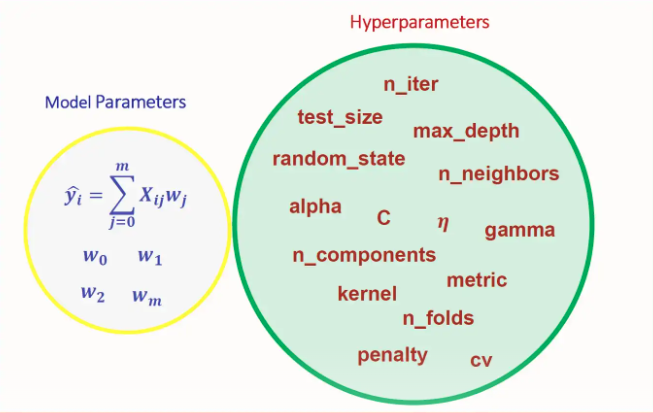

## HPO(Hyper Parameter Optimization)

하이퍼 파라미터는 최적의 학습 모델을 구현하기 위해 사용자가 지정해주는 값

- learning rate, max_depth, n_estimators등 모델별 다양한 변수들이 하이퍼 파라미터에 해당
- 설정한 하이퍼 파라미터 값에 따라 모델의 성능이 달라지기 때문에 파라미터 값을 조정하여 최적의 조합을 찾는 것이 중요

![](https://miro.medium.com/max/1400/1*UMtPi1QBHpfE4iF_egJ8sQ.gif)

# HPO 탐색 방법

HPO를 위해서 결정해야 하는 것은 2가지가 있다.
- 하이퍼 파라미터 탐색 범위
- 하이퍼 파라미터 탐색 정책(방법)


In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
df = sns.load_dataset('titanic')
cols = ["age", "sibsp", "parch", "fare"]
features = df[cols]
target = df['survived']

In [4]:
from sklearn.preprocessing import OneHotEncoder

cols = ["pclass", "sex", "embarked"]

enc = OneHotEncoder(handle_unknown='ignore')
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

features = pd.concat([features, tmp], axis=1)

In [5]:
features.age = features.age.fillna(features.age.median())

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [7]:
from sklearn.model_selection import KFold, cross_val_predict, train_test_split

random_state=42

X_tr, X_te, y_tr, y_te = train_test_split(
    features, target, test_size=0.20,
    shuffle=True, random_state=random_state
)

X_tr.shape, X_te.shape

((712, 13), (179, 13))

In [8]:
n_iter = 50
num_folds = 2
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

In [9]:
def print_scores(y_te,pred):
    print(confusion_matrix(y_te,pred))
    print('-'*50)
    print(classification_report(y_te,pred))

LGBMClassifier Hyper Parameter

- 주요 파리미터
  - n_estimators : 모델에서 사용할 트리 갯수(학습시 생성할 트리 갯수)
  - learning_rate : 학습률
  - criterion : 분할 품질을 측정하는 기능 (default : gini)
  - max_depth : 트리의 최대 깊이
  - min_samples_split : 내부 노드를 분할하는데 필요한 최소 샘플 수 (default : 2)
  - min_samples_leaf : 리프 노드에 있어야 할 최소 샘플 수 (default : 1)
  - min_weight_fraction_leaf : min_sample_leaf와 같지만 가중치가 부여된 샘플 수에서의 비율
  - max_features : 각 노드에서 분할에 사용할 특징의 최대 수
  - max_leaf_nodes : 리프 노드의 최대수
  - min_impurity_decrease : 최소 불순도
  - min_impurity_split : 나무 성장을 멈추기 위한 임계치
  - bootstrap : 부트스트랩(중복허용 샘플링) 사용 여부

In [10]:
from lightgbm.sklearn import LGBMClassifier

## Manual Search
> 사람이 수동으로 파라미터를 변경하는 작업

In [11]:
hp = {
    "max_depth": 5,
    "criterion" : "gini",
    "n_estimators" : 50,
    "learning_rate" : 0.1
}

model = LGBMClassifier(**hp, random_state=random_state).fit(X_tr,y_tr)

pred = model.predict(X_te)
print_scores(y_te, pred)

[LightGBM] [Warning] Unknown parameter: criterion
[[93 12]
 [21 53]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



In [12]:
hp = {
    "max_depth": 4,
    "criterion" : "entropy",
    "n_estimators" : 150,
    "learning_rate" : 0.01
}

model = LGBMClassifier(**hp, random_state=random_state).fit(X_tr,y_tr)
pred = model.predict(X_te)
print_scores(y_te, pred)

[LightGBM] [Warning] Unknown parameter: criterion
[[93 12]
 [24 50]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       105
           1       0.81      0.68      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



## Grid Search

- 특정 하이퍼 파라미터 구간에서 일정 간격으로 값을 선택하여 탐색
- 선택된 모든 값을 탐색하여 최적해를 찾는 가장 기본적이고 간단한 HPO 기법
- 구간 전역을 탐색하기 때문에 탐색 시간이 오래 걸림
- 균일한 간격으로 탐색하기 때문에 최적해를 찾지 못하는 경우가 발생할 수 있음

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "criterion" : ["gini","entropy"], # 순수도 척도
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}
model = LGBMClassifier(random_state=random_state)

gs=GridSearchCV(model, hp, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=False).fit(X_tr,y_tr)

[LightGBM] [Warning] Unknown parameter: criterion


In [15]:
gs.best_params_

{'criterion': 'gini',
 'learning_rate': 0.001,
 'max_depth': 6,
 'n_estimators': 1100}

In [16]:
gs.best_score_

0.8389356255214173

In [17]:
gs.score(X_te, y_te)

0.8875160875160876

In [18]:
pred = gs.predict_proba(X_te)[:,1]
roc_auc_score(y_te, pred)

0.8875160875160876

In [19]:
pred = gs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[[94 11]
 [26 48]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       105
           1       0.81      0.65      0.72        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



<AxesSubplot: xlabel='param_criterion', ylabel='param_n_estimators'>

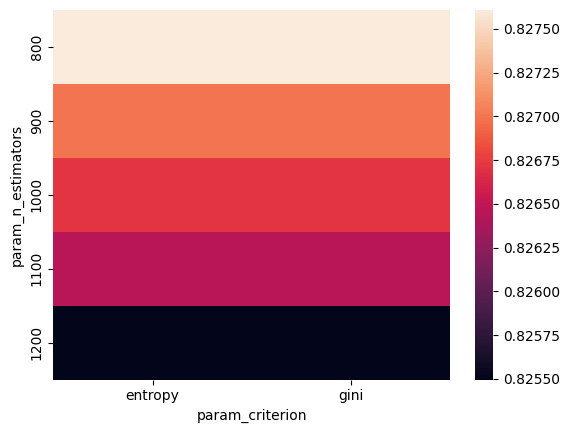

In [20]:
table = pd.pivot_table(pd.DataFrame(gs.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
    columns='param_criterion')

sns.heatmap(table)

criterion의 종류는 결과에 전혀 영향을 미치지 않는다는 것을 확인할 수 있다.

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

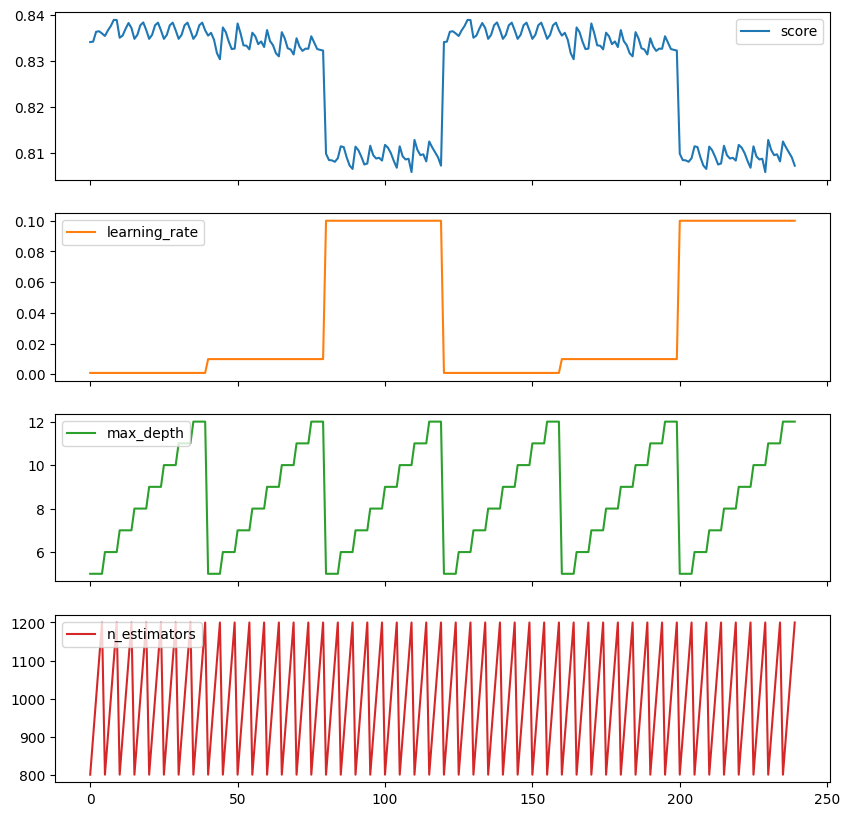

In [21]:
gs_results_df=pd.DataFrame(np.transpose([gs.cv_results_['mean_test_score'],
                                        gs.cv_results_['param_learning_rate'].data,
                                        gs.cv_results_['param_max_depth'].data,
                                        gs.cv_results_['param_n_estimators'].data]),
                            columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

learning_rate가 다른 hyperparameter보다 성능에 영향을 크게 미친다는 것을 확인할 수 있다.

## Random Search

- 탐색 구간 안에서 임의로 파라미터 값을 선택
- 그리드 서치의 문제점(속도)을 보완하기 위해 고안된 방법
- 구간 내 랜덤 조합을 사용하기 때문에 많은 지점을 확인 가능
- 불필요한 반복 탐색이 줄어 그리드 서치보다 탐색 속도가 빠름

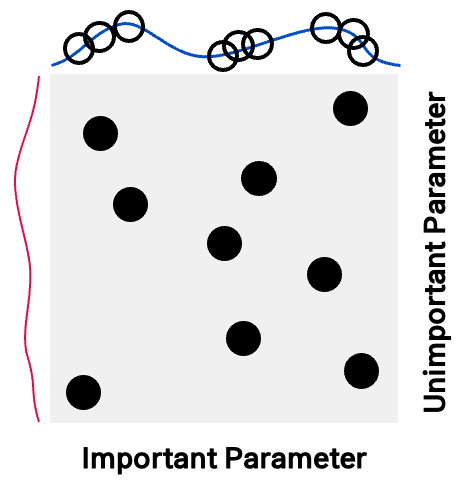

In [22]:
from sklearn.model_selection import RandomizedSearchCV

In [23]:
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "criterion" : ["gini","entropy"], # 순수도 척도
    "n_estimators" : np.linspace(800,1200,5, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}
model = LGBMClassifier(random_state=random_state)

rs=RandomizedSearchCV(model, hp, scoring='roc_auc', n_iter=n_iter, n_jobs=-1, cv=kf, verbose=False).fit(X_tr, y_tr)
rs.best_score_, rs.score(X_te, y_te)

[LightGBM] [Warning] Unknown parameter: criterion


(0.8389356255214173, 0.8875160875160876)

In [24]:
pred = rs.predict_proba(X_te)[:, 1]
roc_auc_score(y_te, pred)

0.8875160875160876

In [25]:
pred = rs.best_estimator_.predict(X_te)
print_scores(y_te, pred)

[[94 11]
 [26 48]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       105
           1       0.81      0.65      0.72        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



<AxesSubplot: xlabel='param_criterion', ylabel='param_n_estimators'>

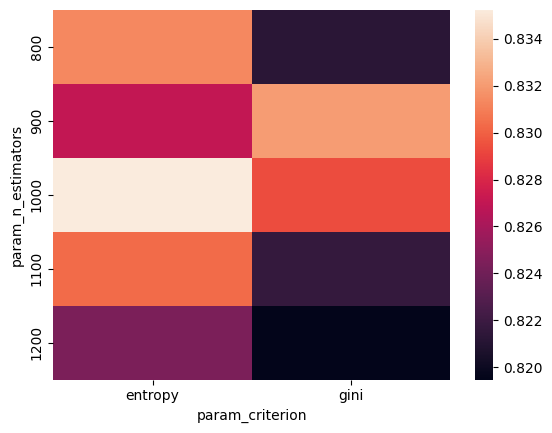

In [26]:
table = pd.pivot_table(pd.DataFrame(rs.cv_results_),
    values='mean_test_score', index='param_n_estimators',
    columns='param_criterion')
sns.heatmap(table)

In [27]:
table

param_criterion,entropy,gini
param_n_estimators,,
800,0.831326,0.821228
900,0.827012,0.832042
1000,0.835235,0.829330
1100,0.830332,0.821622
1200,0.824411,0.819464


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

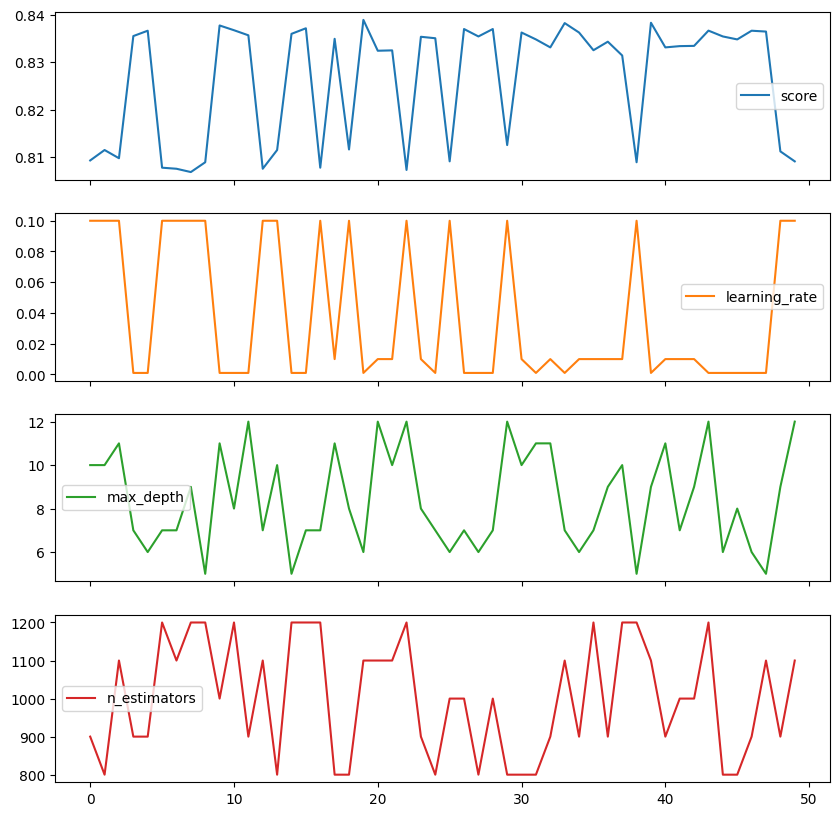

In [28]:
rs_results_df=pd.DataFrame(np.transpose([rs.cv_results_['mean_test_score'],
                                        rs.cv_results_['param_learning_rate'].data,
                                        rs.cv_results_['param_max_depth'].data,
                                        rs.cv_results_['param_n_estimators'].data]),
                            columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

Text(0, 0.5, 'best_cumulative_score')

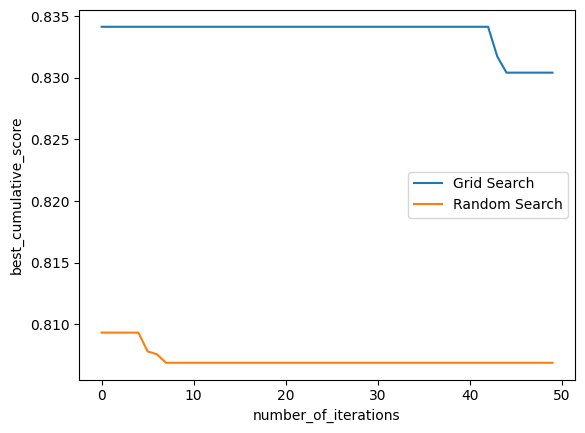

In [29]:
scores_df=pd.DataFrame(index=range(n_iter))
scores_df['Grid Search']=gs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()

ax = scores_df.plot()
ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

## Bayesian Search

- 매회 새로운 하이퍼파라미터값에 대한 조사를 수행할 시 사전 지식을 반영하면서 전체적인 탐색 과정을 체계적으로 수행할 수 있는 방법
- '대체모델'이라는 것을 이용하여 이전 하이퍼파라미터 조합의 적용 결과를 기반으로 더 높은 성능 점수를 얻는 하이퍼파라미터 조합을 예측하는 방식

![](https://github.com/hyeonsangjeon/Hyperparameters-Optimization/raw/master/pic/BayesianOpt.gif?raw=true)

### 일반적 Search의 단점

> Manual Search, Grid Search, Random Search 등을 각 파라미터를 놀릴 뿐이지, 최적의 파라미터를 찾아주지는 못한다.  
이런 단점들을 해결하기 위해 나온 방법론이 Bayesian Optimization이다.

아래는 왜 다른 방법들은 최적의 파라미터를 찾기 힘든지를 나타낸다.

![](https://blog.kakaocdn.net/dn/CI1D9/btqBs0kusd9/k7K6n7H75Yo9mZsll2IKO0/img.gif)

### [optuna 라이브러리](https://optuna.readthedocs.io/en/stable/)

In [30]:
import optuna
from sklearn.model_selection import cross_val_score

### [TPESampler](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html)

In [31]:
from optuna.samplers import TPESampler
optuna.logging.disable_default_handler()

목적 함수

In [32]:
class Objective:
    def __init__(self, x_train, y_train, seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds = 3
        self.cv = KFold(n_splits=num_folds, shuffle=True, random_state=self.seed)
    def __call__(self, trial):
        hp = {
            "max_depth": trial.suggest_int("max_depth", 2, 5),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
            "criterion": trial.suggest_categorical("criterion",["gini", "entropy"]),
            "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 5, 10),
            "n_estimators": trial.suggest_int("n_estimators", 10, 500, 50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1)
        }
        model = LGBMClassifier(random_state=self.seed, **hp)
        scores = cross_val_score(model, self.x_train, self.y_train, cv=self.cv, scoring="roc_auc")
        return np.mean(scores)

학습

In [33]:
sampler = TPESampler(seed=random_state) # 대체 모델

# 스터디 객체
study = optuna.create_study(
    direction="maximize", # maximize | maximize
    sampler=sampler
)
objective = Objective(X_tr, y_tr, random_state)
study.optimize(objective, n_trials=50)

print("Best Score:", study.best_value) # 최고 점수
print("Best hp", study.best_params) # 최고 점수의 하이퍼파라미터 조합

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=10 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] num_leaves is 

In [34]:
model = LGBMClassifier(random_state=random_state, **study.best_params)
model.fit(X_tr, y_tr)

pred = model.predict_proba(X_te)[:,1]
roc_auc_score(y_te, pred)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=9 will be ignored. Current value: num_leaves=31


0.8967824967824969

In [35]:
optuna.visualization.plot_param_importances(study)